# BiLSTM with CRF Layer approach for detecting rare diseases

This notebook contains the code to develop a BiLSTM plus a CRF layer model to detect rare diseases from texts.

It can use random initialization or pre-trained word embeddings to initializate the vectors for the tokens in the texts.

It can also include a CRF layer. 

First, we declare some variables to save paths that will be used in this notebook.


In [1]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    from google.colab import drive
    #drive.flush_and_unmount()
    drive.mount('/content/drive')
    root = '/content/drive/My Drive/Colab Notebooks'
else:
    print('Not running on CoLab')
    root = './'

print("Current directory: {}".format(root))

Running on CoLab
Mounted at /content/drive
Current directory: /content/drive/My Drive/Colab Notebooks


In [2]:
!pip install tensorflow-gpu==1.13.1
!pip install keras==2.2.4
%tensorflow_version 1.x

import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
print('Tensorflow version used: {}'.format(tf.__version__))

# If not working try
# !pip install tensorflow==2.1.0

     |████████████████████████████████| 345.0MB 27kB/s 
     |████████████████████████████████| 368kB 44.6MB/s 
     |████████████████████████████████| 3.2MB 40.0MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 1.13.1 which is incompatible.
ERROR: tensorflow 2.5.0 has requirement tensorflow-estimator<2.6.0,>=2.5.0rc0, but you'll have tensorflow-estimator 1.13.0 which is incompatible.
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
     |████████████████████████████████| 317kB 7.2MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
TensorFlow 1.x selected.
[name: "/device:CPU:0"
de

In [3]:
LANG = 'en'  #This system will also process texts written in Spanish, LANG='es'
allTypes = True
sTypes = ''
if allTypes:
    sTypes = '_all'
usesCRF = '-CRF'

random_initialization = 0 #1 use random initialization, 0 uses pre-trained word embeddings

#path_data=root+'data/{}/'.format(LANG) #folder where you can find the datasets
path_data = root + '/ner/data/gold_nlp4rare_corpus/' #folder where you can find the datasets
path_models = root + '/ner/models/{}/'.format(LANG) #folder to save the models
checkpoints = root + '/ner/checkpoints/'
path_scores = root + '/ner/scores/{}/'.format(LANG) #folder to save the scores
path_outputs = root + '/ner/outputs/{}/'.format(LANG) #folder to save the scores

print('Datasets:',path_data)
print('Path to save this model:',path_models)
print('Path for checkpoints:',checkpoints)
print('Path to save the scores:',path_scores)
print('Path to save the outputs:',path_outputs)

Datasets: /content/drive/My Drive/Colab Notebooks/ner/data/gold_nlp4rare_corpus/
Path to save this model: /content/drive/My Drive/Colab Notebooks/ner/models/en/
Path for checkpoints: /content/drive/My Drive/Colab Notebooks/ner/checkpoints/
Path to save the scores: /content/drive/My Drive/Colab Notebooks/ner/scores/en/
Path to save the outputs: /content/drive/My Drive/Colab Notebooks/ner/outputs/en/


## Random initialization or word embeddings???

Our texts can be represented with random initialization or with pre-trained word embeddings models

If our system uses word embeddings to initialize the vectors for our network, we need to load a pre-trained word embedding model. 

The following cell contains the code need to do this:

In [4]:
import time
import numpy as np

if random_initialization==0:
    models = {'Google News':'GoogleNews-vectors-negative300.bin.gz', 'GloVe':'glove.840B.300d.zip', 'Wiki-PubMed-PMC':'wikipedia-pubmed-and-PMC-w2v.bin'}
    model_used = models['Wiki-PubMed-PMC'] # Change for desired model
    path_w2v = root+'/word_embedding/'+model_used # Change for correct path to the model folder
    print("Charging word embedding model {}...".format(model_used))

    if model_used == 'GoogleNews-vectors-negative300.bin.gz' or model_used == 'wikipedia-pubmed-and-PMC-w2v.bin':
        from gensim.models import KeyedVectors
        start_time = time.time()
        modelw2v = KeyedVectors.load_word2vec_format(path_w2v, binary=True)

    elif model_used == 'glove.840B.300d.zip':
        import zipfile # It allows to manage the file compressed
        start_time = time.time()
        modelw2v = {}
        with zipfile.ZipFile(path_w2v) as zf:
            with zf.open('glove.840B.300d.txt') as f:
                for line in f:
                    values = line.decode('utf-8').split(' ')
                    word = values[0]
                    coefs = np.asarray([float(val) for val in values[1:]])
                    modelw2v[word] = coefs
            zf.close()
  
    # Some metrics
    execution_time = time.time() - start_time
    print("Elapsed Time:\n\t{:.2f} seconds\n\t{:.2f} min".format(execution_time, execution_time/60))
    print("Model loaded")

else:
    print('Random initialization')

Charging word embedding model wikipedia-pubmed-and-PMC-w2v.bin...
Elapsed Time:
	110.75 seconds
	1.85 min
Model loaded


## 1) Loading the data and creating the vocabulary

The input of a neural network model cannot be texts. So, we need to tranform texts into number. In this approach, we are going to represent each words as integer, its index in the vocabulary. This vocabulary is the list of unique words (tokens) from the texts.  To obtains this vocabulary, we consider the texts from training and development datasets. In particular, we need to define the following dictionaries:


- **word_index**: is a dictionary to convert a word into an index value.
- **tag_index** is a dictionary to convert a label into an index value. 

Therefore, first, we need to load the training and development datasets to panda dataframes. 

Moreover, we need to join both datasets into one.

In [5]:
import pandas as pd

df_train = pd.read_csv(path_data+'train{}.csv'.format(sTypes),index_col=0)
print('size of the training dataset: {}'.format(len(df_train)))
df_dev = pd.read_csv(path_data+'dev{}.csv'.format(sTypes),index_col=0)
print('size of the development dataset: {}'.format(len(df_dev)))
df_test = pd.read_csv(path_data+'test{}.csv'.format(sTypes),index_col=0)
print('size of the test dataset: {}'.format(len(df_test)))
print('datasets loaded!\n')

#number of labels (IOB tags)
tags = df_train['Tag'].unique()
num_tags = df_train['Tag'].nunique()
print('Labels: {}'.format(tags))
print('Nr of labels: {}'.format(num_tags))

# Overall statistics for the number of words in each text
count_df_train = df_train.groupby('Sentence #').count()
statistics_train = count_df_train['Word'].describe()
print('\nSome statistics of the sentences in the training dataset:')
print(statistics_train)

count_df_dev = df_dev.groupby('Sentence #').count()
statistics_dev = count_df_dev['Word'].describe()
print('\nSome statistics of the sentences in the development dataset:')
print(statistics_dev)

#The lenth of the longest sentence. Lenght is the number of words.
MAX_LEN_TRAIN = int(statistics_train['max'])
MAX_LEN_DEV = int(statistics_dev['max'])
MAX_LEN = max(MAX_LEN_TRAIN, MAX_LEN_DEV)
print('\n')
print('The maximum length of sentences in TRAIN is: ', MAX_LEN_TRAIN)
print('The maximum length of sentences in DEV is: ', MAX_LEN_DEV)
print('The maximum length of sentences in TOTAL is:', MAX_LEN)

size of the training dataset: 135656
size of the development dataset: 18492
size of the test dataset: 37837
datasets loaded!

Labels: ['O' 'B-RAREDISEASE' 'I-RAREDISEASE' 'B-DISEASE' 'I-DISEASE' 'B-SIGN'
 'I-SIGN' 'B-SYMPTOM' 'I-SYMPTOM']
Nr of labels: 9

Some statistics of the sentences in the training dataset:
count    6451.000000
mean       21.028678
std        10.653876
min         1.000000
25%        13.000000
50%        19.000000
75%        26.000000
max        90.000000
Name: Word, dtype: float64

Some statistics of the sentences in the development dataset:
count    903.000000
mean      20.478405
std       10.105284
min        1.000000
25%       13.000000
50%       18.000000
75%       25.000000
max       71.000000
Name: Word, dtype: float64


The maximum length of sentences in TRAIN is:  90
The maximum length of sentences in DEV is:  71
The maximum length of sentences in TOTAL is: 90


## Create the vocabulary

We need to build the vocabulary from the training (and validation texts). This vocabulary contains the list of unique words in these texts. The vocabulary is a dictionary with the words (as keys) and its corresponding frequencies. The words in the dictionary are sorted by its frecuencies. 

To obtain this vocabulary, we can use the class Tokenizer provided by Keras. Please, note that this tokenizer keeps the index 0 for pad tokens

In [6]:
from keras.preprocessing.text import Tokenizer
MAX_FEATURES = 20000 # this is the number of words we care about, we only consider the 20000 words most common 

full_train_df = pd.concat([df_train, df_dev], ignore_index=True).copy()
words = full_train_df['Word'].values

tokenizer = Tokenizer(num_words=MAX_FEATURES, filters='\t\n')

#this methods creates the dictionary (which contains the unique words from words)
tokenizer.fit_on_texts(words)
#this is the vocabulary. 
word_index = tokenizer.word_index  
#the tokenizer keeps the index 0 for pad tokens
print('Size of the vocabulary:', len(word_index))

#We also have to create a dictionary for the labels (IOB labels):
# label is key and value is index.
tag_index = {t : i + 1 for i, t in enumerate(tags)}
# we have to add a new label for pad tokens
tag_index["PAD"] = 0

print('Dictionary for labels:', tag_index)
print('Number of tags added the tag for pad tokens:', len(tag_index))

Using TensorFlow backend.


Size of the vocabulary: 8916
Dictionary for labels: {'O': 1, 'B-RAREDISEASE': 2, 'I-RAREDISEASE': 3, 'B-DISEASE': 4, 'I-DISEASE': 5, 'B-SIGN': 6, 'I-SIGN': 7, 'B-SYMPTOM': 8, 'I-SYMPTOM': 9, 'PAD': 0}
Number of tags added the tag for pad tokens: 10



### Create the word embedding matrix

In [7]:
def getEmbeddingMatrix(word_index, MAX_FEATURES, model, dimensionality):
    """This functions creates a matrix where each file is a word embedding vector.
      Inputs:
          word_index = refers to the tokenized word index from our dataset
          MAX_FEATURES = refers to the maximum vocabulary size desired
          model = refers to the word embedding dictionary model used
          dimensionality = refers to the size of the one-dimensional vectors in the word embedding model used
    """
    
    # first create a matrix of zeros, this is our embedding matrix
    num_words = min(MAX_FEATURES, len(word_index)) + 1 # +1 because of the padding token
    print("Nr of words [(maximum vocabulary size | word_index) +1 padded]: {}".format(num_words))
    embedding_matrix = np.zeros((num_words, dimensionality), dtype=np.float32)

    # for each word in our word_index lets get the equivalent model vector
    for word, i in word_index.items():
        if i > MAX_FEATURES:
            continue
        if word in model:
            embedding_matrix[i] = model[word]
        # If word doesn't exist in model, let the vector of zeros

    #print (count," ",num_words)
    print("Shape of the embedding matrix: {}".format(embedding_matrix.shape))
    print("Nr of words inside the model: {}".format(int((np.count_nonzero(embedding_matrix, axis=None))/dimensionality)))
    return embedding_matrix, num_words


if random_initialization==1:
    dim_embedding = 300 #by default, 300 dimension for the vectors representing the tokens
    print("No Embedding matrix needed")
else:
    dim_embedding = 300 #by default, 300 dimension for the vectors representing the tokens
    if model_used == 'wikipedia-pubmed-and-PMC-w2v.bin':
        dim_embedding = 200
    embedding_matrix, num_words = getEmbeddingMatrix(word_index, MAX_FEATURES, modelw2v, dim_embedding)
    print("Embedding matrix for {} model was successfully created".format(model_used))

Nr of words [(maximum vocabulary size | word_index) +1 padded]: 8917
Shape of the embedding matrix: (8917, 200)
Nr of words inside the model: 8383
Embedding matrix for wikipedia-pubmed-and-PMC-w2v.bin model was successfully created


## 2) Vectorization (transforming the texts to numbers)

In [8]:
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

class SentenceGetter(object):
    """This is a class to get sentence. Each sentence will be a list of tuples with its tag and pos."""
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Tag'].values.tolist())]
        self.grouped = self.df.groupby("Sentence #").apply(agg)
        self.sentences = [s for s in self.grouped]
        
    def get_text(self):
        try:
            #s = self.grouped['Sentence: {}'.format(self.n_sent)]
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

def vectorization(df,word_index,tag_index,MAX_LEN):
    """This functions gets the dataframe with the dataset and transform it to vectors. 
    First, its sentences are retrieved. Then, for each sentence, the function creates a list
    with its corresponding indexes. If the word does not exist, it gives 0 for this token.
    In addition to X (which are the sentences transformed to vectors), the functions also
    returns the corresponding labels for each token in one-hot coding"""
    
    df = df[['Sentence #','Word','POS','Tag']]
    
    # Getting full sentences
    getter = SentenceGetter(df)
    sentences = getter.sentences

    # Converting each sentence into list of index from list of tokens
    X = [[word_index.get(w[0], 0) for w in s] for s in sentences]
    X = pad_sequences(maxlen = MAX_LEN, sequences = X, padding = "post")

    # Convert label to index
    y = [[tag_index[w[2]] for w in s] for s in sentences]

    # padding
    y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag_index["PAD"])
    
    # One hot encoded labels
    num_tags = df['Tag'].nunique()
    y = [to_categorical(i, num_classes=num_tags+1) for i in y]
    
    return (X, y)
    

X_train, y_train = vectorization(df_train, word_index, tag_index, MAX_LEN)
X_dev, y_dev = vectorization(df_dev, word_index, tag_index, MAX_LEN)
X_test, y_test = vectorization(df_test, word_index, tag_index, MAX_LEN)

print("Size of training input data : ", X_train.shape)
print("Size of training output data : ", np.array(y_train).shape)

print("Size of validation input data : ", X_dev.shape)
print("Size of validation output data : ", np.array(y_dev).shape)

print("Size of testing input data : ", X_test.shape)
print("Size of testing output data : ", np.array(y_test).shape)

Size of training input data :  (6451, 90)
Size of training output data :  (6451, 90, 10)
Size of validation input data :  (903, 90)
Size of validation output data :  (903, 90, 10)
Size of testing input data :  (1772, 90)
Size of testing output data :  (1772, 90, 10)


## 3) Defining the architecture

We now define our architecture, that is, its layers. Before we have to define some important parameters:

wikipedia
BILSTM-CRF-wikipedia-epochs:20-batchsize:64-dimembeding:200-units:100-date:2021-07-08-sTypes:_all
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-_flp7_rj
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-_flp7_rj
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101078 sha256=08892176fe7912cf6c6afede0293a994b80174fbf604f40fbc08901e86e89fc3
  Stored in directory: /tmp/pip-ephem-wheel-cache-j62dhjkq/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 90)

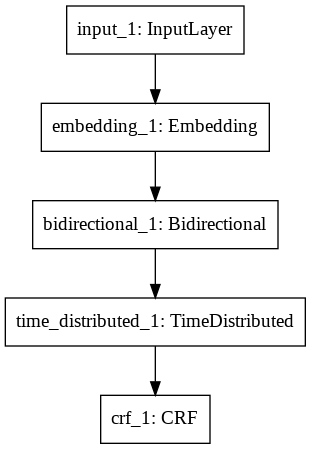

In [9]:
BATCH_SIZE = 64 #64
EPOCHS = 20 #40,20
#MAX_LEN = 75
EMBEDDING = dim_embedding
UNITS=100 #50

if random_initialization==1:
    initialization = 'random'
else:
    initialization = path_w2v[path_w2v.rfind('/')+1:path_w2v.find('-')]
    print(initialization)

from datetime import datetime

today=datetime.today().strftime('%Y-%m-%d')

NAMEMODEL='BILSTM{}-{}-epochs:{}-batchsize:{}-dimembeding:{}-units:{}-date:{}-sTypes:{}'.format(usesCRF, initialization, EPOCHS, BATCH_SIZE, EMBEDDING, UNITS, today, sTypes)
print(NAMEMODEL)

# Installing keras_contrib for CRF layer
!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib import losses, metrics, layers
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy
    
# Model architecture
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional, Input
from keras.models import Model

# Model definition
input = Input(shape=(MAX_LEN,))

# embedding layer
if random_initialization==1:
    model = Embedding(input_dim = len(word_index)+1, output_dim = EMBEDDING, input_length = MAX_LEN, mask_zero = False)(input)
else:
    model= Embedding(input_dim = len(word_index)+1, weights=[embedding_matrix], output_dim = EMBEDDING, input_length = MAX_LEN, mask_zero = False)(input)

# Bilstm layer
model = Bidirectional(LSTM(units = UNITS, return_sequences=True, recurrent_dropout=0.1))(model)

# Variational BiLSTM
model = TimeDistributed(Dense(UNITS, activation="relu"))(model)

# CRF layer
crf = CRF(num_tags+1)  # n_tags+1(PAD)
out = crf(model)

# output
model = Model(input, out)

# Options to compile model
# model.compile(loss=crf.loss, optimizer='adam', metrics=[crf.accuracy])   ### for tf2
# model.compile(optimizer="adam", loss=crf_loss, metrics=[crf_accuracy])
model.compile(optimizer="rmsprop", loss=losses.crf_loss, metrics=[metrics.crf_accuracy])


model.summary()
tf.keras.utils.plot_model(model)
# tf.keras.utils.plot_model(model, to_file = root+'imgs/'+NAMEMODEL+'.png')

## 4) Training the model 


Now we train our model. We use EarlyStopping to avoid overfitting. This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs.

A model is only saved when it provides better performance than previous ones. 



In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkModel = checkpoints + NAMEMODEL + '.h5'

callbacks = [EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
                ModelCheckpoint(filepath=checkModel,verbose=1, monitor='val_loss', 
                             save_best_only=True)]

import time

start = time.time()
from numpy.random import seed
seed(42)
tf.random.set_random_seed(42)
history = model.fit(X_train, np.array(y_train), validation_data=(X_dev, np.array(y_dev)), batch_size=BATCH_SIZE, epochs=EPOCHS,  callbacks=callbacks)
stop = time.time()

trainingTime = round(stop - start,2)
print(f"Training time(s): {trainingTime}s")
print(f"Training time(min): {trainingTime/60} min")
history.history.keys()


Train on 6451 samples, validate on 903 samples
Epoch 1/20
6451/6451 [==============================] - 26s 4ms/step - loss: 0.2068 - crf_accuracy: 0.9353 - val_loss: 0.0975 - val_crf_accuracy: 0.9664

Epoch 00001: val_loss improved from inf to 0.09746, saving model to /content/drive/My Drive/Colab Notebooks/ner/checkpoints/BILSTM-CRF-wikipedia-epochs:20-batchsize:64-dimembeding:200-units:100-date:2021-07-08-sTypes:_all.h5
Epoch 2/20
6451/6451 [==============================] - 24s 4ms/step - loss: 0.0815 - crf_accuracy: 0.9697 - val_loss: 0.0755 - val_crf_accuracy: 0.9721

Epoch 00002: val_loss improved from 0.09746 to 0.07548, saving model to /content/drive/My Drive/Colab Notebooks/ner/checkpoints/BILSTM-CRF-wikipedia-epochs:20-batchsize:64-dimembeding:200-units:100-date:2021-07-08-sTypes:_all.h5
Epoch 3/20
6451/6451 [==============================] - 24s 4ms/step - loss: 0.0607 - crf_accuracy: 0.9754 - val_loss: 0.0599 - val_crf_accuracy: 0.9755

Epoch 00003: val_loss improved from 

dict_keys(['val_loss', 'val_crf_accuracy', 'loss', 'crf_accuracy'])

### Saving the model
We need to save the best model into a variable, bestmodel. Then, the loaded model could be used to evaluate the test dataset. 

We also save the model into the folder models with the name BiLSTM-random.h5.

In [ ]:
from keras.models import load_model
from keras_contrib.metrics import crf_viterbi_accuracy

checkModel=checkpoints+NAMEMODEL+'.h5'

loss = history.history['loss']
val_loss = history.history['val_loss']

def create_custom_objects():
    instanceHolder = {"instance": None}
    class ClassWrapper(CRF):
        def __init__(self, *args, **kwargs):
            instanceHolder["instance"] = self
            super(ClassWrapper, self).__init__(*args, **kwargs)
    def loss(*args):
        method = getattr(instanceHolder["instance"], "loss_function")
        return method(*args)
    def accuracy(*args):
        method = getattr(instanceHolder["instance"], "accuracy")
        return method(*args)
    return {"ClassWrapper": ClassWrapper ,"CRF": ClassWrapper, "loss": loss, "accuracy":accuracy}

def load_keras_model(path):
    model = load_model(path, custom_objects=create_custom_objects())
    return model

#model = load_model(checkModel,custom_objects={'CRF':CRF,'crf_loss':crf_loss,'crf_viterbi_accuracy':crf_viterbi_accuracy,'loss':loss,'val_loss':val_loss})
custom_objects={'CRF': CRF,'crf_loss':crf_loss,'crf_accuracy':crf_viterbi_accuracy}
# model = load_model(checkModel,custom_objects=custom_objects)      

#model=load_keras_model(checkModel)
# print('model loaded into the variable bestmodel')

#we now save the model
model.save(path_models+NAMEMODEL+'.h5')
print('model was saved into the file:',path_models+NAMEMODEL+'.h5')

model was saved into the file: /content/drive/My Drive/Colab Notebooks/ner/models/en/BILSTM-CRF-wikipedia-epochs:20-batchsize:64-dimembeding:200-units:100-date:2021-06-23-sTypes:_all.h5


If you already have a trained model, it is possible to skip the training phase. 


In [ ]:
loadModel=False

if loadModel:
    !pip install h5py==2.10.0 # Keras bug
    custom_objects={'CRF':CRF, 'crf_loss':crf_loss, 'crf_viterbi_accuracy':crf_viterbi_accuracy}
    model = load_model(path_models+NAMEMODEL+'.h5', custom_objects = custom_objects)
    print('model loaded from the file:',path_models+NAMEMODEL+'.h5')

## 5) Testing the model 

We can now apply the model over the test dataset to measure its results. The test dataset was already loaded and processed to prepare the input of the network. 

In [11]:
# Evaluation
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_gold = np.argmax(y_test, -1)

# Convert the index to tag
idx2tag = {i: w for w, i in tag_index.items()}
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_gold = [[idx2tag[i] for i in row] for row in y_gold]

print('Predictions completed')

### Saving the predictions
#We also save the predictions and the gold-standard outputs into files. These files will allow us to perform an error anlysis. 
file_outputs = path_outputs + NAMEMODEL + '.npy'
np.save(file_outputs, y_pred)
np.save(path_outputs + 'y_gold_test.npy', y_gold)
print('Predictions saved' + file_outputs)

### Cleaning the predictions from padding
no_padded_y_gold = []
no_padded_y_pred = []

for g, p in zip(y_gold, y_pred):
    clean_g = [value for value in g if value != 'PAD']
    no_padded_y_gold.append(clean_g)
    threshold = len(clean_g)
    clean_p = p[:threshold]
    no_padded_y_pred.append(clean_p)

Predictions completed
Predictions saved/content/drive/My Drive/Colab Notebooks/ner/outputs/en/BILSTM-CRF-wikipedia-epochs:20-batchsize:64-dimembeding:200-units:100-date:2021-07-08-sTypes:_all.npy


### Showing (and saving) the results

We can see than our model achieves very high average scores. This is because the tag 'O' (which has many examples) helps to increase these average results. However, the scores for the other individual tags  are much lower. 



In [12]:
!pip install sklearn-crfsuite
from sklearn_crfsuite.metrics import flat_classification_report

if allTypes:
    labels=['B-DISEASE','I-DISEASE','B-RAREDISEASE','I-RAREDISEASE','B-SYMPTOM','I-SYMPTOM','B-SIGN','I-SIGN','O']
else:
    labels=['B-RAREDISEASE','I-RAREDISEASE','B-SIGN-SYM','I-SIGN-SYM','O']

# Results including 'O' tag
metric1 = flat_classification_report(no_padded_y_gold, no_padded_y_pred, labels=labels, digits=4) # individual tags evaluation
print('BiLSTM results (including the class O):')
print('Language:'+ LANG + '\n')
print(metric1)

file_scores = path_scores + NAMEMODEL + '.txt'
f = open(file_scores, "w")

# Results without including 'O' tag
labels.remove('O')
report = flat_classification_report(no_padded_y_gold, no_padded_y_pred, labels=labels, digits=4) # individual tags evaluation

# Prints
print('BiLSTM results (without including the class O):')
print('Language:'+ LANG + '\n')
print(report)

f.write('BiLSTM results (without including the class O)\n')
f.write('Language:'+ LANG + '\n')

data=report.split('\n')
for line in data:
    if len(line.strip())==0 or 'precision' in line:
        pass
    else:
        if ' avg' in line:
            line=line.replace(' avg','-avg')
        line=line.strip()
        line=' '.join(line.split())

        line=line.replace(' ','\t&\t')+'\\\\'
        if line.startswith('weighted'):
            line='\\hline %'+line
        
        print(line)
        f.write(line)

f.write('\n\n')
f.write('Training times:{}(s)'.format(str(trainingTime)))
f.close()
print('Scores were saved to path: ' + file_scores)

     |████████████████████████████████| 747kB 10.2MB/s 
BiLSTM results (including the class O):
Language:en

               precision    recall  f1-score   support

    B-DISEASE     0.7616    0.5192    0.6174       443
    I-DISEASE     0.7789    0.5550    0.6482       400
B-RAREDISEASE     0.6617    0.8295    0.7361      1073
I-RAREDISEASE     0.7694    0.8346    0.8007      1179
    B-SYMPTOM     0.7273    0.6400    0.6809        50
    I-SYMPTOM     0.6296    0.2125    0.3178        80
       B-SIGN     0.5919    0.6015    0.5967       803
       I-SIGN     0.5929    0.5589    0.5754      2215
            O     0.9530    0.9485    0.9507     31594

    micro avg     0.9052    0.9003    0.9027     37837
    macro avg     0.7185    0.6333    0.6582     37837
 weighted avg     0.9052    0.9003    0.9017     37837

BiLSTM results (without including the class O):
Language:en

               precision    recall  f1-score   support

    B-DISEASE     0.7616    0.5192    0.6174       443
 

We now obtain the results at the level of entity. To do this, we use the seqeval library

In [13]:
!pip install seqeval
from seqeval.metrics import classification_report
from seqeval.scheme import IOB2
#IOB2: It is same as IOB, except that the B- tag is used in the beginning of every chunk (i.e. all chunks start with the B- tag).

f=open(file_scores, "a")

report = classification_report(no_padded_y_gold, no_padded_y_pred, scheme=IOB2, digits=4)
f.write('BiLSTM results on entity (approximate):\n')
print('BiLSTM results on entity (approximate):')
print('Language:'+ LANG+ '\n')
print(report)

data=report.split('\n')
for line in data:
    if len(line.strip())==0 or 'precision' in line:
        pass
    else:
        if ' avg' in line:
            line=line.replace(' avg','-avg')
        line=line.strip()
        line=' '.join(line.split())

        line=line.replace(' ','\t&\t')+'\\\\'
        if line.startswith('weighted'):
            line='\hline%'+line
        print(line)
        f.write(line)

f.close() 
print('Scores were saved to path: ' + file_scores)

     |████████████████████████████████| 51kB 4.5MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16184 sha256=9cdc8327835feb938f6312e3edc4ebb32da3a7d18350c8f6fee2884820fd0ebd
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


BiLSTM results on entity (approximate):
Language:en

              precision    recall  f1-score   support

          AD     0.0000    0.0000    0.0000         0
     DISEASE     0.7208    0.4890    0.5827       454
 RAREDISEASE     0.6339    0.7890    0.7030      1095
        SIGN     0.4994    0.4562    0.4768       958
     SYMPTOM     0.6739    0.5741    0.6200        54

   micro avg     0.5564    0.6068    0.5805      2561
   macro avg     0.5056    0.4617    0.4765      2561
weighted avg     0.5998    0.6068    0.5953      2561

AD	&	0.0000	&	0.0000	&	0.0000	&	0\\
DISEASE	&	0.7208	&	0.4890	&	0.5827	&	454\\
RAREDISEASE	&	0.6339	&	0.7890	&	0.7030	&	1095\\
SIGN	&	0.4994	&	0.4562	&	0.4768	&	958\\
SYMPTOM	&	0.6739	&	0.5741	&	0.6200	&	54\\
micro-avg	&	0.5564	&	0.6068	&	0.5805	&	2561\\
macro-avg	&	0.5056	&	0.4617	&	0.4765	&	2561\\
\hline%weighted-avg	&	0.5998	&	0.6068	&	0.5953	&	2561\\
Scores were saved to path: /content/drive/My Drive/Colab Notebooks/ner/scores/en/BILSTM-CRF-wikipedia

Scenarios:

    - I. Surface string and entity type match
    - II. System hypothesized an entity
    - III. System misses an entity
    - IV. System assigns the wrong entity type
    - V. System gets the boundaries of the surface string wrong
    - VI. System gets the boundaries and entity type wrong

MUC metrics:

    - Correct (COR) : both are the same
    - Incorrect (INC) : the output of a system and the golden annotation don’t match
    - Partial (PAR) : system and the golden annotation are somewhat “similar” but not the same
    - Missing (MIS) : a golden annotation is not captured by a system
    - Spurius (SPU) : system produces a response which doesn’t exist in the golden annotation

Four different ways to measure precision/recall/f1-score:

    - Strict: exact boundary surface string match and entity type
    - Exact: exact boundary match over the surface string, regardless of the type
    - Partial: partial boundary match over the surface string, regardless of the type
    - Type: some overlap between the system tagged entity and the gold annotation is required


In [14]:
import logging
from collections import namedtuple
from copy import deepcopy

logging.basicConfig(
    format="%(asctime)s %(name)s %(levelname)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="DEBUG",
)

Entity = namedtuple("Entity", "e_type start_offset end_offset")

class Evaluator():

    def __init__(self, true, pred, tags):
        """
        """

        if len(true) != len(pred):
            raise ValueError("Number of predicted documents does not equal true")

        self.true = true
        self.pred = pred
        self.tags = tags

        # Setup dict into which metrics will be stored.

        self.metrics_results = {
            'correct': 0,
            'incorrect': 0,
            'partial': 0,
            'missed': 0,
            'spurious': 0,
            'possible': 0,
            'actual': 0,
            'precision': 0,
            'recall': 0,
        }

        # Copy results dict to cover the four schemes.

        self.results = {
            'strict': deepcopy(self.metrics_results),
            'ent_type': deepcopy(self.metrics_results),
            'partial':deepcopy(self.metrics_results),
            'exact':deepcopy(self.metrics_results),
            }

        # Create an accumulator to store results

        self.evaluation_agg_entities_type = {e: deepcopy(self.results) for e in tags}


    def evaluate(self):

        logging.info(
            "Imported %s predictions for %s true examples",
            len(self.pred), len(self.true)
        )

        for true_ents, pred_ents in zip(self.true, self.pred):

            # Check that the length of the true and predicted examples are the
            # same. This must be checked here, because another error may not
            # be thrown if the lengths do not match.

            if len(true_ents) != len(pred_ents):
                raise ValueError("Prediction length does not match true example length")

            # Compute results for one message

            tmp_results, tmp_agg_results = compute_metrics(
                collect_named_entities(true_ents),
                collect_named_entities(pred_ents),
                self.tags
            )

            # Cycle through each result and accumulate

            # TODO: Combine these loops below:

            for eval_schema in self.results:

                for metric in self.results[eval_schema]:

                    self.results[eval_schema][metric] += tmp_results[eval_schema][metric]

            # Calculate global precision and recall

            self.results = compute_precision_recall_wrapper(self.results)

            # Aggregate results by entity type

            for e_type in self.tags:

                for eval_schema in tmp_agg_results[e_type]:

                    for metric in tmp_agg_results[e_type][eval_schema]:

                        self.evaluation_agg_entities_type[e_type][eval_schema][metric] += tmp_agg_results[e_type][eval_schema][metric]

                # Calculate precision recall at the individual entity level

                self.evaluation_agg_entities_type[e_type] = compute_precision_recall_wrapper(self.evaluation_agg_entities_type[e_type])

        return self.results, self.evaluation_agg_entities_type


def collect_named_entities(tokens):
    """
    Creates a list of Entity named-tuples, storing the entity type and the start and end
    offsets of the entity.
    :param tokens: a list of tags
    :return: a list of Entity named-tuples
    """

    named_entities = []
    start_offset = None
    end_offset = None
    ent_type = None

    for offset, token_tag in enumerate(tokens):

        if token_tag == 'O':
            if ent_type is not None and start_offset is not None:
                end_offset = offset - 1
                named_entities.append(Entity(ent_type, start_offset, end_offset))
                start_offset = None
                end_offset = None
                ent_type = None

        elif ent_type is None:
            ent_type = token_tag[2:]
            start_offset = offset

        elif ent_type != token_tag[2:] or (ent_type == token_tag[2:] and token_tag[:1] == 'B'):

            end_offset = offset - 1
            named_entities.append(Entity(ent_type, start_offset, end_offset))

            # start of a new entity
            ent_type = token_tag[2:]
            start_offset = offset
            end_offset = None

    # catches an entity that goes up until the last token

    if ent_type is not None and start_offset is not None and end_offset is None:
        named_entities.append(Entity(ent_type, start_offset, len(tokens)-1))

    return named_entities


def compute_metrics(true_named_entities, pred_named_entities, tags):


    eval_metrics = {'correct': 0, 'incorrect': 0, 'partial': 0, 'missed': 0, 'spurious': 0, 'precision': 0, 'recall': 0}

    # overall results
    
    evaluation = {
        'strict': deepcopy(eval_metrics),
        'ent_type': deepcopy(eval_metrics),
        'partial': deepcopy(eval_metrics),
        'exact': deepcopy(eval_metrics)
    }

    # results by entity type

    evaluation_agg_entities_type = {e: deepcopy(evaluation) for e in tags}

    # keep track of entities that overlapped

    true_which_overlapped_with_pred = []

    # Subset into only the tags that we are interested in.
    # NOTE: we remove the tags we don't want from both the predicted and the
    # true entities. This covers the two cases where mismatches can occur:
    #
    # 1) Where the model predicts a tag that is not present in the true data
    # 2) Where there is a tag in the true data that the model is not capable of
    # predicting.

    true_named_entities = [ent for ent in true_named_entities if ent.e_type in tags]
    pred_named_entities = [ent for ent in pred_named_entities if ent.e_type in tags]

    # go through each predicted named-entity

    for pred in pred_named_entities:
        found_overlap = False

        # Check each of the potential scenarios in turn. See
        # http://www.davidsbatista.net/blog/2018/05/09/Named_Entity_Evaluation/
        # for scenario explanation.

        # Scenario I: Exact match between true and pred

        if pred in true_named_entities:
            true_which_overlapped_with_pred.append(pred)
            evaluation['strict']['correct'] += 1
            evaluation['ent_type']['correct'] += 1
            evaluation['exact']['correct'] += 1
            evaluation['partial']['correct'] += 1

            # for the agg. by e_type results
            evaluation_agg_entities_type[pred.e_type]['strict']['correct'] += 1
            evaluation_agg_entities_type[pred.e_type]['ent_type']['correct'] += 1
            evaluation_agg_entities_type[pred.e_type]['exact']['correct'] += 1
            evaluation_agg_entities_type[pred.e_type]['partial']['correct'] += 1

        else:

            # check for overlaps with any of the true entities

            for true in true_named_entities:

                pred_range = range(pred.start_offset, pred.end_offset)
                true_range = range(true.start_offset, true.end_offset)

                # Scenario IV: Offsets match, but entity type is wrong

                if true.start_offset == pred.start_offset and pred.end_offset == true.end_offset \
                        and true.e_type != pred.e_type:

                    # overall results
                    evaluation['strict']['incorrect'] += 1
                    evaluation['ent_type']['incorrect'] += 1
                    evaluation['partial']['correct'] += 1
                    evaluation['exact']['correct'] += 1

                    # aggregated by entity type results
                    evaluation_agg_entities_type[true.e_type]['strict']['incorrect'] += 1
                    evaluation_agg_entities_type[true.e_type]['ent_type']['incorrect'] += 1
                    evaluation_agg_entities_type[true.e_type]['partial']['correct'] += 1
                    evaluation_agg_entities_type[true.e_type]['exact']['correct'] += 1

                    true_which_overlapped_with_pred.append(true)
                    found_overlap = True

                    break

                # check for an overlap i.e. not exact boundary match, with true entities

                elif find_overlap(true_range, pred_range):

                    true_which_overlapped_with_pred.append(true)

                    # Scenario V: There is an overlap (but offsets do not match
                    # exactly), and the entity type is the same.
                    # 2.1 overlaps with the same entity type

                    if pred.e_type == true.e_type:

                        # overall results
                        evaluation['strict']['incorrect'] += 1
                        evaluation['ent_type']['correct'] += 1
                        evaluation['partial']['partial'] += 1
                        evaluation['exact']['incorrect'] += 1

                        # aggregated by entity type results
                        evaluation_agg_entities_type[true.e_type]['strict']['incorrect'] += 1
                        evaluation_agg_entities_type[true.e_type]['ent_type']['correct'] += 1
                        evaluation_agg_entities_type[true.e_type]['partial']['partial'] += 1
                        evaluation_agg_entities_type[true.e_type]['exact']['incorrect'] += 1

                        found_overlap = True

                        break

                    # Scenario VI: Entities overlap, but the entity type is
                    # different.

                    else:
                        # overall results
                        evaluation['strict']['incorrect'] += 1
                        evaluation['ent_type']['incorrect'] += 1
                        evaluation['partial']['partial'] += 1
                        evaluation['exact']['incorrect'] += 1

                        # aggregated by entity type results
                        # Results against the true entity

                        evaluation_agg_entities_type[true.e_type]['strict']['incorrect'] += 1
                        evaluation_agg_entities_type[true.e_type]['partial']['partial'] += 1
                        evaluation_agg_entities_type[true.e_type]['ent_type']['incorrect'] += 1
                        evaluation_agg_entities_type[true.e_type]['exact']['incorrect'] += 1

                        # Results against the predicted entity

                        # evaluation_agg_entities_type[pred.e_type]['strict']['spurious'] += 1

                        found_overlap = True

                        break

            # Scenario II: Entities are spurious (i.e., over-generated).

            if not found_overlap:

                # Overall results

                evaluation['strict']['spurious'] += 1
                evaluation['ent_type']['spurious'] += 1
                evaluation['partial']['spurious'] += 1
                evaluation['exact']['spurious'] += 1

                # Aggregated by entity type results

                # NOTE: when pred.e_type is not found in tags
                # or when it simply does not appear in the test set, then it is
                # spurious, but it is not clear where to assign it at the tag
                # level. In this case, it is applied to all target_tags
                # found in this example. This will mean that the sum of the
                # evaluation_agg_entities will not equal evaluation.

                for true in tags:                    

                    evaluation_agg_entities_type[true]['strict']['spurious'] += 1
                    evaluation_agg_entities_type[true]['ent_type']['spurious'] += 1
                    evaluation_agg_entities_type[true]['partial']['spurious'] += 1
                    evaluation_agg_entities_type[true]['exact']['spurious'] += 1

    # Scenario III: Entity was missed entirely.

    for true in true_named_entities:
        if true in true_which_overlapped_with_pred:
            continue
        else:
            # overall results
            evaluation['strict']['missed'] += 1
            evaluation['ent_type']['missed'] += 1
            evaluation['partial']['missed'] += 1
            evaluation['exact']['missed'] += 1

            # for the agg. by e_type
            evaluation_agg_entities_type[true.e_type]['strict']['missed'] += 1
            evaluation_agg_entities_type[true.e_type]['ent_type']['missed'] += 1
            evaluation_agg_entities_type[true.e_type]['partial']['missed'] += 1
            evaluation_agg_entities_type[true.e_type]['exact']['missed'] += 1

    # Compute 'possible', 'actual' according to SemEval-2013 Task 9.1 on the
    # overall results, and use these to calculate precision and recall.

    for eval_type in evaluation:
        evaluation[eval_type] = compute_actual_possible(evaluation[eval_type])

    # Compute 'possible', 'actual', and precision and recall on entity level
    # results. Start by cycling through the accumulated results.

    for entity_type, entity_level in evaluation_agg_entities_type.items():

        # Cycle through the evaluation types for each dict containing entity
        # level results.

        for eval_type in entity_level:

            evaluation_agg_entities_type[entity_type][eval_type] = compute_actual_possible(
                entity_level[eval_type]
            )

    return evaluation, evaluation_agg_entities_type


def find_overlap(true_range, pred_range):
    """Find the overlap between two ranges
    Find the overlap between two ranges. Return the overlapping values if
    present, else return an empty set().
    Examples:
    >>> find_overlap((1, 2), (2, 3))
    2
    >>> find_overlap((1, 2), (3, 4))
    set()
    """

    true_set = set(true_range)
    pred_set = set(pred_range)

    overlaps = true_set.intersection(pred_set)

    return overlaps


def compute_actual_possible(results):
    """
    Takes a result dict that has been output by compute metrics.
    Returns the results dict with actual, possible populated.
    When the results dicts is from partial or ent_type metrics, then
    partial_or_type=True to ensure the right calculation is used for
    calculating precision and recall.
    """

    correct = results['correct']
    incorrect = results['incorrect']
    partial = results['partial']
    missed = results['missed']
    spurious = results['spurious']

    # Possible: number annotations in the gold-standard which contribute to the
    # final score

    possible = correct + incorrect + partial + missed

    # Actual: number of annotations produced by the NER system

    actual = correct + incorrect + partial + spurious

    results["actual"] = actual
    results["possible"] = possible

    return results


def compute_precision_recall(results, partial_or_type=False):
    """
    Takes a result dict that has been output by compute metrics.
    Returns the results dict with precison and recall populated.
    When the results dicts is from partial or ent_type metrics, then
    partial_or_type=True to ensure the right calculation is used for
    calculating precision and recall.
    """

    actual = results["actual"]
    possible = results["possible"]
    partial = results['partial']
    correct = results['correct']

    if partial_or_type:
        precision = (correct + 0.5 * partial) / actual if actual > 0 else 0
        recall = (correct + 0.5 * partial) / possible if possible > 0 else 0

    else:
        precision = correct / actual if actual > 0 else 0
        recall = correct / possible if possible > 0 else 0

    results["precision"] = precision
    results["recall"] = recall

    return results


def compute_precision_recall_wrapper(results):
    """
    Wraps the compute_precision_recall function and runs on a dict of results
    """

    results_a = {key: compute_precision_recall(value, True) for key, value in results.items() if
                 key in ['partial', 'ent_type']}
    results_b = {key: compute_precision_recall(value) for key, value in results.items() if
                 key in ['strict', 'exact']}

    results = {**results_a, **results_b}

    return results

In [15]:
random_df = df_test[['Sentence #','Word','POS','Tag']].copy()
# Getting full sentences
getter_random = SentenceGetter(random_df)
sentences_random = getter_random.sentences

import random

random.seed(42)
result_examples_idx = random.sample(range(len(no_padded_y_gold)), k=30)
result_examples_y_gold = list()
result_examples_y_pred = list()
original_sentences = list()

for idx in result_examples_idx:
    result_examples_y_gold.append(no_padded_y_gold[idx])
    result_examples_y_pred.append(no_padded_y_pred[idx])
    original_sentences.append(sentences_random[idx])

itr = 0
for g, p, s in zip(result_examples_y_gold, result_examples_y_pred, original_sentences):
    assert len(g) == len(p), 'Results does not seem to be the same'
    print('Sentence Nr: ', result_examples_idx[itr])
    original_s = pd.Series(s, name='WORD')
    df = pd.DataFrame(original_s)
    df['GOLD'] = g
    df['PRED'] = p
    print(df)
    itr += 1
    print()

Sentence Nr:  1309
                            WORD           GOLD           PRED
0                  (The, DET, O)              O              O
1            (symptoms, NOUN, O)              O              O
2                (and, CCONJ, O)              O              O
3                  (the, DET, O)              O              O
4             (physical, ADJ, O)              O              O
5            (findings, NOUN, O)              O              O
6          (associated, VERB, O)              O              O
7                 (with, ADP, O)              O              O
8   (ASLD, PROPN, B-RAREDISEASE)  B-RAREDISEASE  B-RAREDISEASE
9                (vary, VERB, O)              O              O
10             (greatly, ADV, O)              O              O
11                (from, ADP, O)              O              O
12               (case, NOUN, O)              O              O
13                  (to, ADP, O)              O              O
14               (case, NOUN, O)    

In [16]:
if allTypes:
    test_labels = ['DISEASE', 'RAREDISEASE', 'SYMPTOM', 'SIGN']
else:
    test_labels = ['RAREDISEASE', 'SIGN-SYM']

test_to_use_gold = result_examples_y_gold
test_to_use_pred = result_examples_y_pred

evaluator_examples = Evaluator(test_to_use_gold, test_to_use_pred, test_labels)
results_examples, results_agg_examples = evaluator_examples.evaluate()

print('## OVERALL RESULTS')
for item in results_examples.keys():
    print('\tEvaluation Metric: ', item)
    print('\t', results_examples[item])
print('## RESULTS AT ENTITY LEVEL')
for entity in results_agg_examples.keys():
    print('Entity: ', entity)
    for item in results_agg_examples[entity].keys():
        print('\tEvaluation Metric: ', item)
        print('\t', results_agg_examples[entity][item])

2021-07-08 11:00:27 root INFO: Imported 30 predictions for 30 true examples


## OVERALL RESULTS
	Evaluation Metric:  ent_type
	 {'correct': 34, 'incorrect': 6, 'partial': 0, 'missed': 10, 'spurious': 10, 'possible': 50, 'actual': 50, 'precision': 0.68, 'recall': 0.68}
	Evaluation Metric:  partial
	 {'correct': 36, 'incorrect': 0, 'partial': 4, 'missed': 10, 'spurious': 10, 'possible': 50, 'actual': 50, 'precision': 0.76, 'recall': 0.76}
	Evaluation Metric:  strict
	 {'correct': 30, 'incorrect': 10, 'partial': 0, 'missed': 10, 'spurious': 10, 'possible': 50, 'actual': 50, 'precision': 0.6, 'recall': 0.6}
	Evaluation Metric:  exact
	 {'correct': 36, 'incorrect': 4, 'partial': 0, 'missed': 10, 'spurious': 10, 'possible': 50, 'actual': 50, 'precision': 0.72, 'recall': 0.72}
## RESULTS AT ENTITY LEVEL
Entity:  DISEASE
	Evaluation Metric:  ent_type
	 {'correct': 9, 'incorrect': 5, 'partial': 0, 'missed': 5, 'spurious': 10, 'possible': 19, 'actual': 24, 'precision': 0.375, 'recall': 0.47368421052631576}
	Evaluation Metric:  partial
	 {'correct': 14, 'incorrect': 0, 'p

In [17]:
evaluator_all = Evaluator(no_padded_y_gold, no_padded_y_pred, test_labels)
results_all, results_agg_all = evaluator_all.evaluate()

print('## OVERALL RESULTS')
for item in results_all.keys():
    print('\tEvaluation Metric: ', item)
    print('\t', results_all[item])
print('## RESULTS AT ENTITY LEVEL')
for entity in results_agg_all.keys():
    print('Entity: ', entity)
    for item in results_agg_all[entity].keys():
        print('\tEvaluation Metric: ', item)
        print('\t', results_agg_all[entity][item])

2021-07-08 11:00:27 root INFO: Imported 1772 predictions for 1772 true examples


## OVERALL RESULTS
	Evaluation Metric:  ent_type
	 {'correct': 1725, 'incorrect': 241, 'partial': 0, 'missed': 607, 'spurious': 626, 'possible': 2573, 'actual': 2592, 'precision': 0.6655092592592593, 'recall': 0.6704236300038865}
	Evaluation Metric:  partial
	 {'correct': 1758, 'incorrect': 0, 'partial': 208, 'missed': 607, 'spurious': 626, 'possible': 2573, 'actual': 2592, 'precision': 0.7183641975308642, 'recall': 0.723668869024485}
	Evaluation Metric:  strict
	 {'correct': 1554, 'incorrect': 412, 'partial': 0, 'missed': 607, 'spurious': 626, 'possible': 2573, 'actual': 2592, 'precision': 0.5995370370370371, 'recall': 0.6039642440730665}
	Evaluation Metric:  exact
	 {'correct': 1758, 'incorrect': 208, 'partial': 0, 'missed': 607, 'spurious': 626, 'possible': 2573, 'actual': 2592, 'precision': 0.6782407407407407, 'recall': 0.6832491255343957}
## RESULTS AT ENTITY LEVEL
Entity:  DISEASE
	Evaluation Metric:  ent_type
	 {'correct': 229, 'incorrect': 137, 'partial': 0, 'missed': 90, 'spur